# Dependencies

In [1]:
!pip install category_encoders
!pip install xgboost
!pip install scikit-optimize

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
import statsmodels.api as sm
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
import plotly.graph_objs as go
from plotly.offline import iplot
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.svm import SVC
from xgboost import XGBClassifier
import random
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import joblib

# Load Dataframe

In [3]:
# Load dataset
df = pd.read_csv('predictive_maintenance.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [4]:
# Shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,4576,M19435,M,302.9,311.0,1437,49.9,55,0,No Failure
1,7553,L54732,L,300.3,311.3,1525,40.7,105,0,No Failure
2,6159,L53338,L,301.1,311.0,1677,29.1,188,0,No Failure
3,6611,L53790,L,301.5,310.4,1543,34.0,55,0,No Failure
4,810,L47989,L,296.9,307.6,1452,45.7,122,0,No Failure


# EDA & Preprocessing

In [5]:
# Size of Dataset
R = df.shape[0]
C = df.shape[1]
print(f"Number of rows: {R}")
print(f"Number of columns: {C}")

Number of rows: 10000
Number of columns: 10


In [6]:
# dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [7]:
df = df.rename(columns={'Air temperature [K]': 'Air temperature',
                                'Process temperature [K]': 'Process temperature',
                                'Rotational speed [rpm]': 'Rotational speed',
                                'Torque [Nm]': 'Torque',
                                'Tool wear [min]': 'Tool wear',
                                })

In [8]:
df.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature', 'Process temperature',
       'Rotational speed', 'Torque', 'Tool wear', 'Target', 'Failure Type'],
      dtype='object')

In [9]:
# Drop unnecessary columns
df = df.drop(['UDI'], axis=1)
df = df.reset_index(drop=True)
df = df.drop(['Product ID'], axis=1)
df = df.reset_index(drop=True)
df = df.drop(['Target'], axis=1)
df = df.reset_index(drop=True)
df.columns

Index(['Type', 'Air temperature', 'Process temperature', 'Rotational speed',
       'Torque', 'Tool wear', 'Failure Type'],
      dtype='object')

In [10]:
# Drop duplicated rows
print("Number of duplicated rows:", df.shape[0] - df.drop_duplicates().shape[0])
df = df.drop_duplicates()
df = df.reset_index(drop=True)
print()
print("Removing duplicates...")
print()
print("Number of duplicated rows:", df.shape[0] - df.drop_duplicates().shape[0])

Number of duplicated rows: 0

Removing duplicates...

Number of duplicated rows: 0


In [11]:
df["Type"].value_counts()

,count
Type,
L,6000
M,2997
H,1003


In [12]:
df["Failure Type"].value_counts()

,count
Failure Type,
No Failure,9652
Heat Dissipation Failure,112
Power Failure,95
Overstrain Failure,78
Tool Wear Failure,45
Random Failures,18


In [13]:
# Show categorical columns
categorical_cols = list(set(df.columns.to_list()) - set(df._get_numeric_data().columns.to_list()))

print("Categorical columns:")
print(sorted(categorical_cols))

Categorical columns:
['Failure Type', 'Type']


In [14]:
# Encode ordinal data

enc_maps = {
    "Type" : [{'col': "Type", 'mapping': {"L": 0, "M": 1, "H": 2}}],
    "Failure Type" : [{'col': "Failure Type", 'mapping': {
        "No Failure": 0,
        "Heat Dissipation Failure": 1,
        "Power Failure": 2,
        "Overstrain Failure": 3,
        "Tool Wear Failure": 4,
        "Random Failures": 5,
        }}],
}

for col in categorical_cols:
    enc_map = enc_maps[col]

    enc = OrdinalEncoder(mapping=enc_map)
    df = enc.fit_transform(df)

df.head()

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Failure Type
0,1,302.9,311.0,1437,49.9,55,0
1,0,300.3,311.3,1525,40.7,105,0
2,0,301.1,311.0,1677,29.1,188,0
3,0,301.5,310.4,1543,34.0,55,0
4,0,296.9,307.6,1452,45.7,122,0


<Axes: >

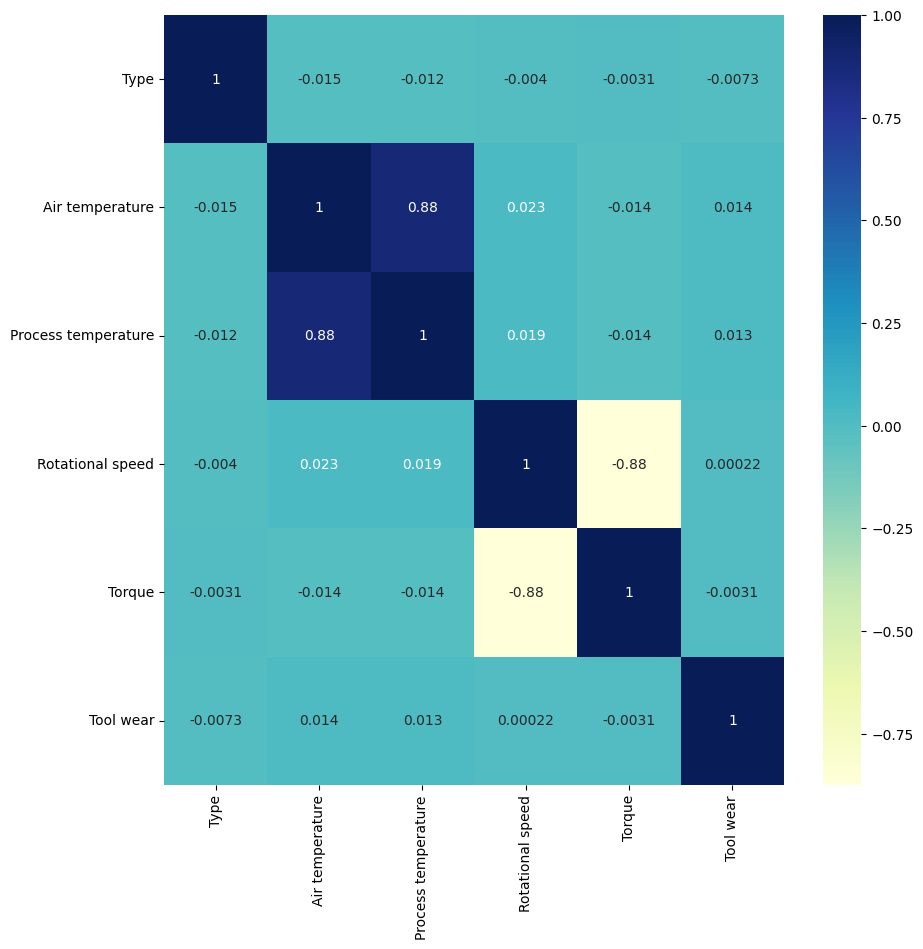

In [15]:
# Displaying heatmap
X = df.drop(['Failure Type'], axis=1)

plt.subplots(figsize=(10, 10))
sns.heatmap(X.corr(method="pearson"), cmap="YlGnBu", annot=True)

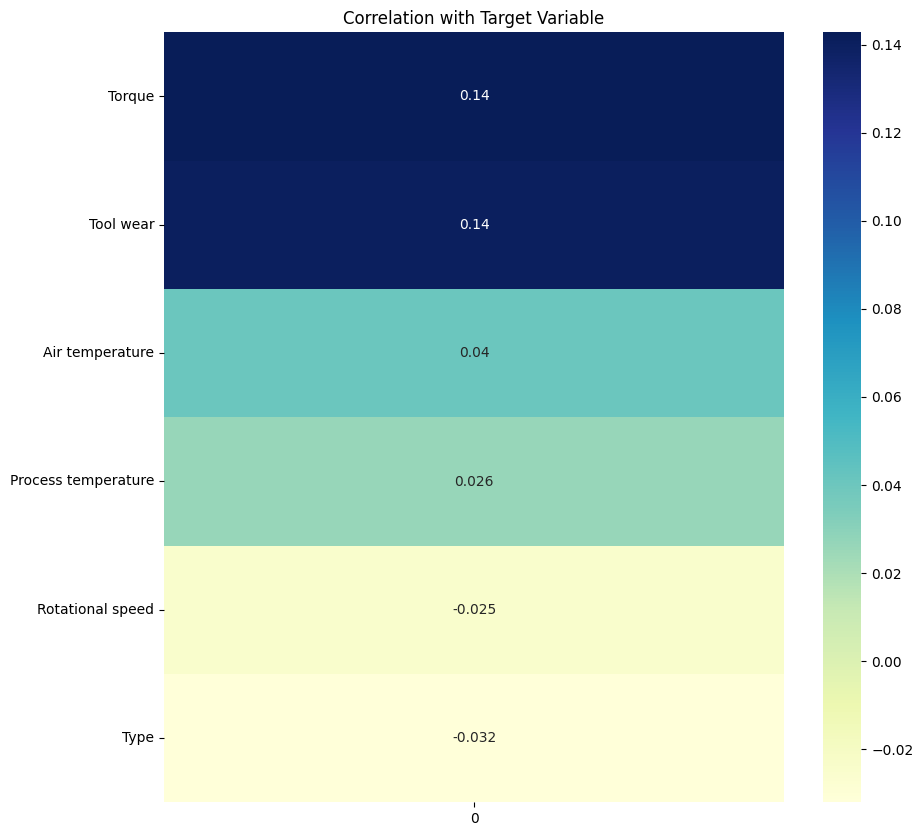

In [16]:
# Create a correlation matrix with target variable
y = df['Failure Type']

corr_with_target = X.corrwith(y)
corr_with_target = corr_with_target.sort_values(ascending=False)
plt.figure(figsize=(10, 10))
sns.heatmap(corr_with_target.to_frame(), cmap='YlGnBu', annot=True)
plt.title('Correlation with Target Variable')
plt.show()

In [17]:
df_original = df.copy()
df_original.head()

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Failure Type
0,1,302.9,311.0,1437,49.9,55,0
1,0,300.3,311.3,1525,40.7,105,0
2,0,301.1,311.0,1677,29.1,188,0
3,0,301.5,310.4,1543,34.0,55,0
4,0,296.9,307.6,1452,45.7,122,0


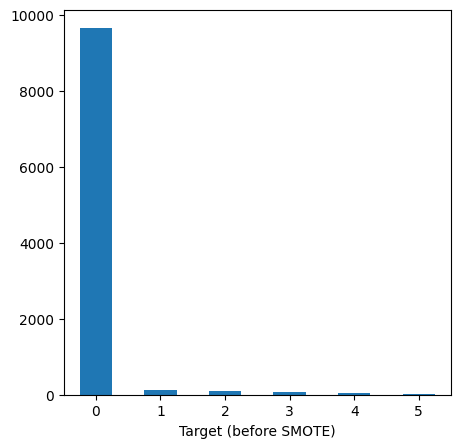

In [18]:
ax = df["Failure Type"].value_counts().sort_index() \
    .plot(kind='bar',
          figsize=(5, 5))
ax.set_xlabel('Target (before SMOTE)')
plt.xticks(rotation=0)
plt.show()

In [19]:
print("Distribusi kelas sebelum SMOTE:", Counter(y))

Distribusi kelas sebelum SMOTE: Counter({0: 9652, 1: 112, 2: 95, 3: 78, 4: 45, 5: 18})


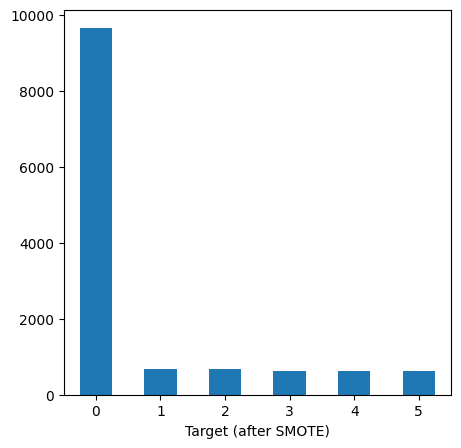

In [20]:
# Oversampling

sampling_strategy = {
    0: 9652,
    1: 672,
    2: 665,
    3: 624,
    4: 630,
    5: 630,
    }
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X, y = smote.fit_resample(X, y)
X = pd.DataFrame(X, columns=X.columns)
y = pd.Series(y)

ax = y.value_counts().sort_index() \
    .plot(kind='bar',
          figsize=(5, 5))
ax.set_xlabel('Target (after SMOTE)')
plt.xticks(rotation=0)
plt.show()

In [21]:
print("After SMOTE:", Counter(y))

After SMOTE: Counter({0: 9652, 1: 672, 2: 665, 4: 630, 5: 630, 3: 624})


# Data Splitting

In [22]:
# Train/Val/Test: 80/10/10

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.11, random_state=42, stratify=y_train_val)

# Modelling

In [23]:
def evaluate_model(model, focus, X_val, y_val, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    TRAIN_LABEL = "TRAINING" if focus == "training" else "Training"
    VAL_LABEL = "VALIDATION" if focus == "validation" else "Validation"
    TEST_LABEL = "TESTING" if focus == "testing" else "Testing"
    CMAP = "viridis" if focus == "training" else ("GnBu" if focus == "validation" else "Greens")

    print(f"{TRAIN_LABEL} acc score:", accuracy_score(y_train, y_train_pred))
    print(f"{TRAIN_LABEL} acc:", y_train.value_counts().max() / len(y_train))
    print()
    print(f"{VAL_LABEL} acc score:", accuracy_score(y_val, y_val_pred))
    print(f"{VAL_LABEL} null acc:", y_val.value_counts().max() / len(y_val))
    print()
    print(f"{TEST_LABEL} acc score:", accuracy_score(y_test, y_test_pred))
    print(f"{TEST_LABEL} null acc:", y_test.value_counts().max() / len(y_test))
    print()

    cm = confusion_matrix(y_val, y_val_pred) if focus == "training" or focus == "validation" else confusion_matrix(y_test, y_test_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in y.unique()])
    disp.plot(cmap = CMAP)
    plt.title("Confusion matrix")
    plt.show()

    print(classification_report(y_val_pred, y_val))

In [24]:
def evaluate_on_original_df(model):
    X_test = df_original.drop(['Failure Type'], axis=1)
    y_test = df_original['Failure Type']

    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in y.unique()])
    disp.plot(cmap = "OrRd")
    plt.title("Original Dataset")
    plt.show()

In [25]:
SPLIT = 5

skf = StratifiedKFold(n_splits=SPLIT, shuffle=True, random_state=42)
X_train_list = []
X_val_list = []
y_train_list = []
y_val_list = []
max_idx = -1

for train_idx, val_idx in skf.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    print(f"{np.sum(y[train_idx] == 0)} out of {len(train_idx)}")
    print(f"{np.sum(y[train_idx] == 1)} out of {len(train_idx)}")
    print(f"{np.sum(y[train_idx] == 2)} out of {len(train_idx)}")
    print(f"{np.sum(y[train_idx] == 3)} out of {len(train_idx)}")
    print(f"{np.sum(y[train_idx] == 4)} out of {len(train_idx)}")
    print(f"{np.sum(y[train_idx] == 5)} out of {len(train_idx)}")
    print()

    X_train_list.append(X_train)
    X_val_list.append(X_val)
    y_train_list.append(y_train)
    y_val_list.append(y_val)

7721 out of 10298
538 out of 10298
532 out of 10298
499 out of 10298
504 out of 10298
504 out of 10298

7721 out of 10298
538 out of 10298
532 out of 10298
499 out of 10298
504 out of 10298
504 out of 10298

7722 out of 10298
537 out of 10298
532 out of 10298
499 out of 10298
504 out of 10298
504 out of 10298

7722 out of 10299
537 out of 10299
532 out of 10299
500 out of 10299
504 out of 10299
504 out of 10299

7722 out of 10299
538 out of 10299
532 out of 10299
499 out of 10299
504 out of 10299
504 out of 10299



## Random Forest

In [26]:
stratified_scores = []

for i in range(SPLIT):
    X_train, X_val, y_train, y_val = X_train_list[i], X_val_list[i], y_train_list[i], y_val_list[i]

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    stratified_scores.append(accuracy_score(y_val, y_pred))

max_idx_rf = np.argmax(stratified_scores)

print(f"Stratified K-Fold scores: {stratified_scores}")
print(f"Mean: {np.mean(stratified_scores):.5f}, Std: {np.std(stratified_scores):.5f}")
print(f"Argmax: {max_idx_rf}")

Stratified K-Fold scores: [0.9662135922330097, 0.9631067961165048, 0.9724271844660194, 0.9665889665889665, 0.9658119658119658]
Mean: 0.96683, Std: 0.00306
Argmax: 2


In [27]:
X_train, X_val, y_train, y_val = X_train_list[max_idx], X_val_list[max_idx], y_train_list[max_idx], y_val_list[max_idx]

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

TRAINING acc score: 1.0
TRAINING acc: 0.749781532187591

Validation acc score: 0.9658119658119658
Validation null acc: 0.7498057498057498

Testing acc score: 0.9953416149068323
Testing null acc: 0.75



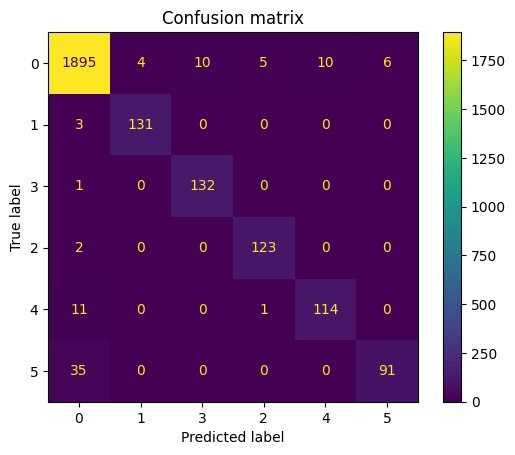

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1947
           1       0.98      0.97      0.97       135
           2       0.99      0.93      0.96       142
           3       0.98      0.95      0.97       129
           4       0.90      0.92      0.91       124
           5       0.72      0.94      0.82        97

    accuracy                           0.97      2574
   macro avg       0.93      0.95      0.93      2574
weighted avg       0.97      0.97      0.97      2574



In [28]:
evaluate_model(rf, "training", X_val, y_val, X_test, y_test)

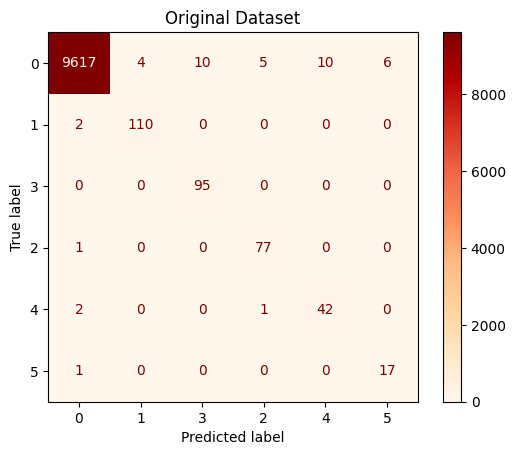

In [29]:
evaluate_on_original_df(rf)

## XGB

In [30]:
stratified_scores = []

for i in range(SPLIT):
    X_train, X_val, y_train, y_val = X_train_list[i], X_val_list[i], y_train_list[i], y_val_list[i]

    model = XGBClassifier(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    stratified_scores.append(accuracy_score(y_val, y_pred))

max_idx_xgb = np.argmax(stratified_scores)

print(f"Stratified K-Fold scores: {stratified_scores}")
print(f"Mean: {np.mean(stratified_scores):.5f}, Std: {np.std(stratified_scores):.5f}")
print(f"Argmax: {max_idx_xgb}")

Stratified K-Fold scores: [0.9724271844660194, 0.9685436893203884, 0.9774757281553398, 0.9696969696969697, 0.9766899766899767]
Mean: 0.97297, Std: 0.00360
Argmax: 2


In [31]:
X_train, X_val, y_train, y_val = X_train_list[max_idx], X_val_list[max_idx], y_train_list[max_idx], y_val_list[max_idx]

xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

TRAINING acc score: 0.9997087095834547
TRAINING acc: 0.749781532187591

Validation acc score: 0.9766899766899767
Validation null acc: 0.7498057498057498

Testing acc score: 0.9961180124223602
Testing null acc: 0.75



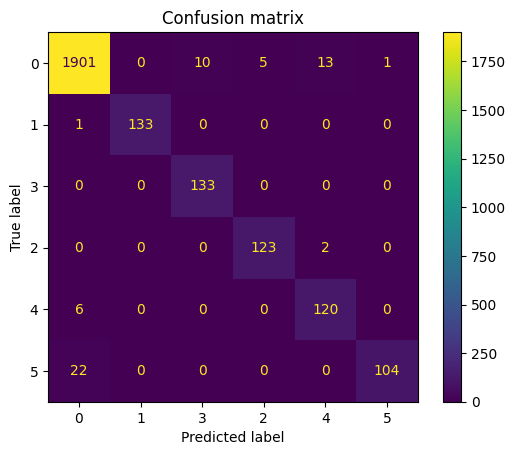

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1930
           1       0.99      1.00      1.00       133
           2       1.00      0.93      0.96       143
           3       0.98      0.96      0.97       128
           4       0.95      0.89      0.92       135
           5       0.83      0.99      0.90       105

    accuracy                           0.98      2574
   macro avg       0.96      0.96      0.96      2574
weighted avg       0.98      0.98      0.98      2574



In [32]:
evaluate_model(xgb, "training", X_val, y_val, X_test, y_test)

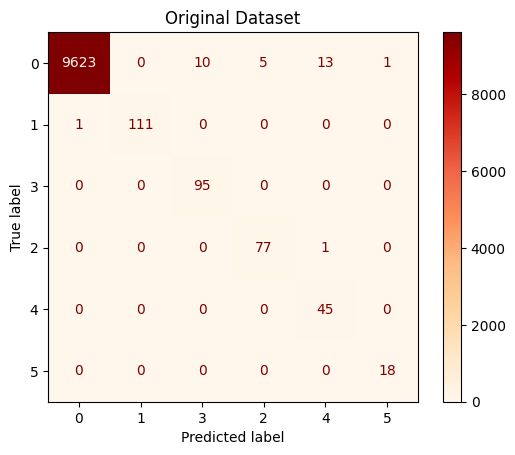

In [33]:
evaluate_on_original_df(xgb)

# Hyperparameter Tuning

In [34]:
model = XGBClassifier(random_state=42)
max_idx = max_idx_xgb
model.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'feature_weights': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [35]:
X_train, X_val, y_train, y_val = X_train_list[max_idx], X_val_list[max_idx], y_train_list[max_idx], y_val_list[max_idx]

train_idx = X_train.index
val_idx = X_val.index

params = {
    'max_depth': [i for i in range(10, 110, 10)],
    'n_estimators': [i for i in range(20, 220, 20)],
    "grow_policy": ["depthwise", "lossguide"],
}

grid_search = GridSearchCV(estimator=model,
                           param_grid=params,
                           cv=[(train_idx, val_idx)], n_jobs=-1, verbose=2, scoring = "accuracy")

In [36]:
%%time
# only indices match train_idx, val_idx will be processed
grid_search.fit(X, y)

Fitting 1 folds for each of 200 candidates, totalling 200 fits
CPU times: user 3.89 s, sys: 235 ms, total: 4.12 s
Wall time: 3min 24s


GridSearchCV(cv=[(Index([    2,     3,     5,     6,     7,     8,     9,    10,    11,    13,
       ...
       12861, 12862, 12863, 12864, 12865, 12866, 12868, 12869, 12871, 12872],
      dtype='int64', length=10298),
                  Index([    0,     1,     4,    12,    14,    25,    26,    27,    30,    31,
       ...
       12827, 12828, 12832, 12836, 12838, 12839, 12842, 12848, 12867, 12870],
      dtype='int64', length=2575))],
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylev...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'grow_policy': ['depthwise', 'lossguide'],
                         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                         'n_estimators': [20, 40, 60, 80, 100, 120, 140, 160,
                                          180, 200]},
             scoring='accuracy', verbose=2)

In [37]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.sort_values('rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_grow_policy,param_max_depth,param_n_estimators,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
6,2.800634,0.0,0.100047,0.0,depthwise,10,140,"{'grow_policy': 'depthwise', 'max_depth': 10, ...",0.979029,0.979029,0.0,1
9,2.353783,0.0,0.111592,0.0,depthwise,10,200,"{'grow_policy': 'depthwise', 'max_depth': 10, ...",0.979029,0.979029,0.0,1
109,2.524890,0.0,0.137163,0.0,lossguide,10,200,"{'grow_policy': 'lossguide', 'max_depth': 10, ...",0.979029,0.979029,0.0,1
106,2.973416,0.0,0.148172,0.0,lossguide,10,140,"{'grow_policy': 'lossguide', 'max_depth': 10, ...",0.979029,0.979029,0.0,1
107,3.499233,0.0,0.093160,0.0,lossguide,10,160,"{'grow_policy': 'lossguide', 'max_depth': 10, ...",0.978641,0.978641,0.0,5
108,2.551114,0.0,0.105046,0.0,lossguide,10,180,"{'grow_policy': 'lossguide', 'max_depth': 10, ...",0.978641,0.978641,0.0,5
8,2.608258,0.0,0.101531,0.0,depthwise,10,180,"{'grow_policy': 'depthwise', 'max_depth': 10, ...",0.978641,0.978641,0.0,5
7,2.953587,0.0,0.091722,0.0,depthwise,10,160,"{'grow_policy': 'depthwise', 'max_depth': 10, ...",0.978641,0.978641,0.0,5
5,2.440278,0.0,0.142321,0.0,depthwise,10,120,"{'grow_policy': 'depthwise', 'max_depth': 10, ...",0.978252,0.978252,0.0,9
105,1.785131,0.0,0.118176,0.0,lossguide,10,120,"{'grow_policy': 'lossguide', 'max_depth': 10, ...",0.978252,0.978252,0.0,9


In [38]:
bayes_params = {
    'max_depth': Integer(1, 30),
    'n_estimators': Integer(140, 200),
    "grow_policy": Categorical(["depthwise", "lossguide"]),
}

model = XGBClassifier(random_state=42)

bayes_search = BayesSearchCV(
    estimator=model,
    search_spaces=bayes_params,
    n_iter=50,  # Number of iterations (adjust as needed)
    cv=[(train_idx, val_idx)],
    n_jobs=-1,
    verbose=2,
    scoring='accuracy',
    random_state=42
)

In [39]:
%%time
bayes_search.fit(X, y)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fi

BayesSearchCV(cv=[(Index([    2,     3,     5,     6,     7,     8,     9,    10,    11,    13,
       ...
       12861, 12862, 12863, 12864, 12865, 12866, 12868, 12869, 12871, 12872],
      dtype='int64', length=10298),
                   Index([    0,     1,     4,    12,    14,    25,    26,    27,    30,    31,
       ...
       12827, 12828, 12832, 12836, 12838, 12839, 12842, 12848, 12867, 12870],
      dtype='int64', length=2575))],
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_byle...
                                      multi_strategy=None, n_estimators=None,
                                      n_jobs=None, num_parallel_tree=None, ...),
              n_jobs=-1, random_state=42, scoring='accuracy',
              search_spaces={'grow_policy': Categorical(categories=('depthwise', 'lossguide'), prior=None),
                             'max_depth': Integer(low=1, high=30, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=140, high=200, prior='uniform', transform='normalize')},
              verbose=2)

In [40]:
print(bayes_search.best_params_)

print("Best cross-validation score:", bayes_search.best_score_)

OrderedDict({'grow_policy': 'depthwise', 'max_depth': 7, 'n_estimators': 200})
Best cross-validation score: 0.9801941747572815


Training acc score: 1.0
Training acc: 0.7498543406486696

VALIDATION acc score: 1.0
VALIDATION null acc: 0.7495145631067961

Testing acc score: 1.0
Testing null acc: 0.75



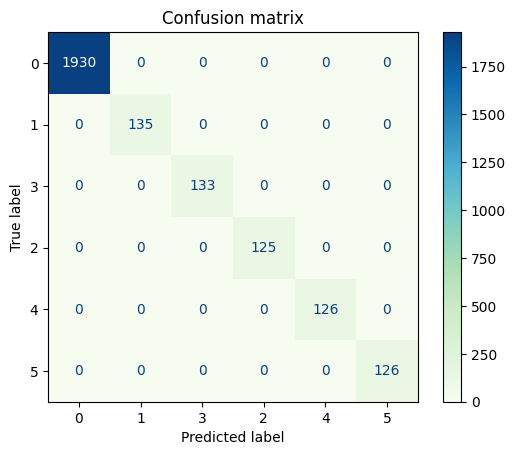

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1930
           1       1.00      1.00      1.00       135
           2       1.00      1.00      1.00       133
           3       1.00      1.00      1.00       125
           4       1.00      1.00      1.00       126
           5       1.00      1.00      1.00       126

    accuracy                           1.00      2575
   macro avg       1.00      1.00      1.00      2575
weighted avg       1.00      1.00      1.00      2575



In [41]:
model = bayes_search.best_estimator_
evaluate_model(model, "validation", X_val, y_val, X_test, y_test)

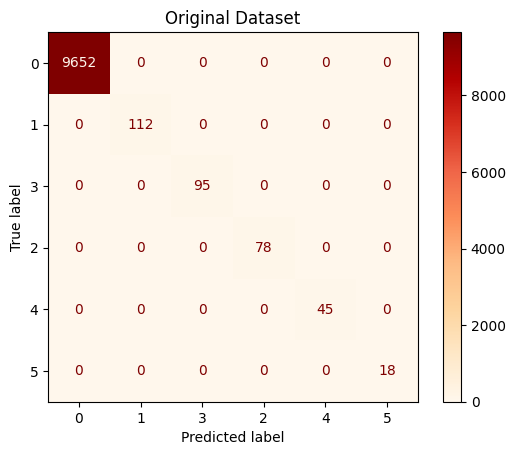

In [42]:
evaluate_on_original_df(model)

In [43]:
# Let's check if tuned_model can generalise well to other dataset
# Don't use any random_state argument!

dummy_stratified_scores = []

dummy_skf = StratifiedKFold(n_splits=SPLIT, shuffle=True)

for dummy_train_idx, dummy_val_idx in dummy_skf.split(X, y):
    dummy_X_train, dummy_X_val = X.iloc[dummy_train_idx], X.iloc[dummy_val_idx]
    dummy_y_train, dummy_y_val = y[dummy_train_idx], y[dummy_val_idx]

    dummy_model = XGBClassifier(bayes_search.best_params_)
    dummy_model.fit(dummy_X_train, dummy_y_train)

    dummy_y_val_pred = model.predict(dummy_X_val)
    dummy_stratified_scores.append(accuracy_score(dummy_y_val, dummy_y_val_pred))

dummy_max_idx = np.argmax(dummy_stratified_scores)

print(f"Stratified K-Fold scores: {dummy_stratified_scores}")
print(f"Mean: {np.mean(dummy_stratified_scores):.5f}, Std: {np.std(dummy_stratified_scores):.5f}")
print(f"Argmax: {dummy_max_idx}")

/usr/local/lib/python3.12/dist-packages/xgboost/core.py:726: FutureWarning:

Pass `objective` as keyword args.

/usr/local/lib/python3.12/dist-packages/xgboost/core.py:726: FutureWarning:

Pass `objective` as keyword args.

/usr/local/lib/python3.12/dist-packages/xgboost/core.py:726: FutureWarning:

Pass `objective` as keyword args.

/usr/local/lib/python3.12/dist-packages/xgboost/core.py:726: FutureWarning:

Pass `objective` as keyword args.

/usr/local/lib/python3.12/dist-packages/xgboost/core.py:726: FutureWarning:

Pass `objective` as keyword args.



Stratified K-Fold scores: [1.0, 1.0, 1.0, 1.0, 1.0]
Mean: 1.00000, Std: 0.00000
Argmax: 0


# Evaluation

Training acc score: 1.0
Training acc: 0.7498543406486696

Validation acc score: 1.0
Validation null acc: 0.7495145631067961

TESTING acc score: 1.0
TESTING null acc: 0.75



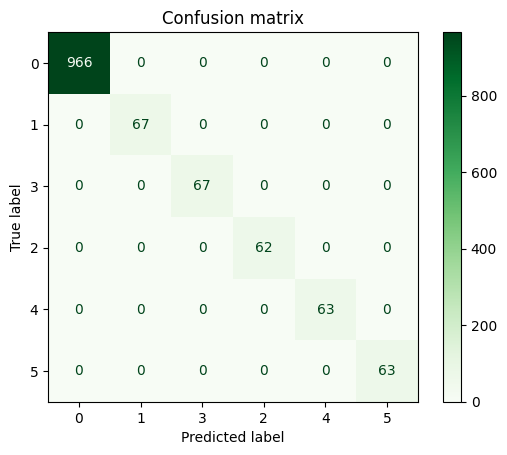

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1930
           1       1.00      1.00      1.00       135
           2       1.00      1.00      1.00       133
           3       1.00      1.00      1.00       125
           4       1.00      1.00      1.00       126
           5       1.00      1.00      1.00       126

    accuracy                           1.00      2575
   macro avg       1.00      1.00      1.00      2575
weighted avg       1.00      1.00      1.00      2575



In [44]:
evaluate_model(model, "testing", X_val, y_val, X_test, y_test)

# Save Model

In [45]:
joblib.dump(model, 'classifier.h5')

['classifier.h5']